# Dask on an AWS EMR Cluster

This notebook is intended to be run on an AWS EMR cluster, configured using the steps listed in dask_bootstrap_workflow.md tutorial in this directory. The EMR cluster used in this tutorial has two worker m5.xlarge instances within it, each of which has 4 virtual CPU cores and 16 GB of memory (you're welcome to scale your cluster beyond this, though!). If you would like to learn more about working with Dask on EMR clusters, [check out the dask-yarn documentation](https://yarn.dask.org/en/latest/aws-emr.html).

In [1]:
from dask_yarn import YarnCluster
from dask.distributed import Client

/home/hadoop/miniconda/lib/python3.7/site-packages/dask_yarn/core.py:16: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import (
/home/hadoop/miniconda/lib/python3.7/site-packages/dask_yarn/core.py:16: FutureWarning: parse_timedelta is deprecated and will be removed in a future release. Please use dask.utils.parse_timedelta instead.
  from distributed.utils import (


In [2]:
# Create a cluster where each worker has 1 vCPU core and 2 GiB of memory:
# workers ~ processes, worker_vcores ~ threads
cluster = YarnCluster(environment="/home/hadoop/environment.tar.gz",
                      worker_vcores = 1,
                      worker_memory = "2GiB"
                      )

# Scale cluster out to 8 such workers:
cluster.scale(8)

# Connect to the cluster (before proceeding, you should wait for workers to be registered by the dask scheduler, as below):
client = Client(cluster)

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at: tcp://172.31.30.249:44249
distributed.scheduler - INFO -   dashboard at:                    :39197
distributed.scheduler - INFO - Receive client connection: Client-22eb2786-44d0-11ec-8aa8-0ab3823728c1
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <WorkerState 'tcp://172.31.16.126:46769', name: dask.worker_6, status: undefined, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://172.31.16.126:46769
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <WorkerState 'tcp://172.31.16.126:39835', name: dask.worker_2, status: undefined, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://172.31.16.126:39835
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register wo

Once everyone is registered, we can see our workers, virtual cores, and the amount of memory that our cluster is using overall; we can adjust all of this as need be if it doesn't match our hardware well. You click the link below to show your task graphs and execution status of your code as you run it.

In [3]:
client

Connection method: Cluster object,Cluster type: dask_yarn.YarnCluster
Dashboard: /proxy/39197/status,


To start, let's do some simple Dask array operations to demonstrate how arrays and array operations are split up into equal chunks across our 8 workers:

In [4]:
import dask.array as da

n = len(client.scheduler_info()['workers'])
a = da.ones(100, chunks=int(100/n))
a

dask.array<ones_like, shape=(100,), dtype=float64, chunksize=(12,), chunktype=numpy.ndarray>

In [5]:
a.sum().compute()

100.0

In [6]:
x = da.random.random((10000, 10000), chunks=(1000, 1000))
y = x + x.T
y.mean().compute()

0.9999222495708108

We can also interact with large data sources in S3 via Dask DataFrames, using a lot of the familiar methods we employ in smaller scale applications in Pandas. Here, we read in 10GB of Amazon's customer book data and perform a few simple operations. If you take a look at the Dask task graph while this is running, you can see that our groupby and sum operations are being performed in parallel by our workers.

In [7]:
import dask.dataframe as dd

df = dd.read_parquet("s3://amazon-reviews-pds/parquet/product_category=Books/*.parquet",
                     storage_options={'anon': True, 'use_ssl': False},
                     engine='fastparquet')

In [8]:
helpful_by_star = (df[['star_rating', 'helpful_votes']].groupby('star_rating')
                                                       .sum())
helpful_df = helpful_by_star.compute() # returns Pandas DataFrame
helpful_df

,helpful_votes
star_rating,
1,10985502
2,5581929
3,7021927
4,11100563
5,44825468


We can also plot and explore our data using standard Matplotlib plotting functionality:

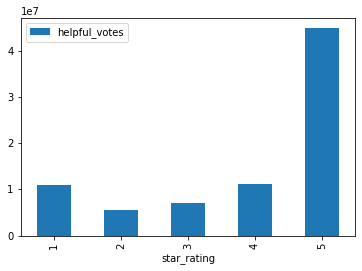

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

helpful_df.plot(kind="bar");

Note, though, that running standard DataFrame operations such as `df.head()` are highly serial operations in Dask (if you attempt to run this method with our current cluster setup, you will run out of memory and your workers will be terminated, because Dask attempts to read and sort a big chunk of the entire dataframe on a single worker (and we only 2 GB).

To run these types of serial operations on your Dask cluster, you'll want to make sure you give your workers enough memory to work with. For instance, here, our workers will need around ~6GB per worker to perform operations like `df.head()`. Let's shutdown our current Dask cluster configuration and launch it again with more memory allocated to each worker (each worker will have 4 vCPUs with 8 GB of shared memory each):

In [ ]:
cluster.shutdown()

In [11]:
# Create a cluster where each worker has 4 vCPU core and 8 GiB of memory:
cluster = YarnCluster(environment="/home/hadoop/environment.tar.gz",
                      worker_vcores = 4,
                      worker_memory = "8GiB"
                      )

# Scale cluster out to 2 such workers:
cluster.scale(2)

# Connect to the cluster (before proceeding, you should wait for workers to be registered by the dask scheduler, as below):
client = Client(cluster)

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at: tcp://172.31.30.249:40361
distributed.scheduler - INFO -   dashboard at:                    :35237
distributed.scheduler - INFO - Receive client connection: Client-84f309be-44d0-11ec-8aa8-0ab3823728c1
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <WorkerState 'tcp://172.31.16.126:34089', name: dask.worker_0, status: undefined, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://172.31.16.126:34089
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <WorkerState 'tcp://172.31.25.65:35543', name: dask.worker_1, status: undefined, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://172.31.25.65:35543
distributed.core - INFO - Starting established connection


In [12]:
client

Connection method: Cluster object,Cluster type: dask_yarn.YarnCluster
Dashboard: /proxy/35237/status,


Then, you'll see that we now have enough memory per worker to complete the `df.head()` operation:

In [13]:
df = dd.read_parquet("s3://amazon-reviews-pds/parquet/product_category=Books/*.parquet",
                     storage_options={'anon': True, 'use_ssl': False},
                     engine='fastparquet')

In [14]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year
0,US,15444933,R1WWG70WK9VUCH,1848192576,835940987,Standing Qigong for Health and Martial Arts - ...,5,9,10,N,Y,Informative AND interesting!,"After attending a few Qigong classes, I wanted...",2015-05-02,2015
1,US,20595117,R1EQ3POS0RIOD5,145162445X,574044348,A Universe from Nothing: Why There Is Somethin...,4,4,7,N,N,Between 'Nothing' and 'Nothing' somehow we are...,Krauss traces the remarkable transformation in...,2012-06-29,2012
2,US,52925878,R10SRJA4VVGUBD,055341805X,846590203,Hyacinth Girls: A Novel,4,0,0,Y,N,Mysteries upon mysteries,"Rebecca, a dental hygienist, receives a call a...",2015-05-02,2015
3,US,40062567,RD3268X41GM7U,0425263908,119148606,Bared to You,5,1,1,N,N,"""RAW, STEAMY, HYPNOTIC!""","\\""BARED TO YOU\\"" is a sizzling, red-hot pass...",2012-06-29,2012
4,US,47221489,R3KGQL5X5BSJE1,1416556141,987400385,Healer: A Novel,5,0,0,N,Y,Well written story,Good characters and plot line. I spent a pleas...,2015-05-02,2015


And, if we take a look at our task stream in our new dashboard, you'll notice that our Dask array operations from before still occur in parallel across 8 threads (mapping onto vCPUs within our 2 Dask workers). Each worker just has more memory available to them and our vCPUs are treated as threads:

In [15]:
x = da.random.random((10000, 10000), chunks=(1000, 1000))
y = x + x.T
y.mean().compute()

1.0000190996120946

Note, though, that not all operations in Python handle multi-threading equally, so it can sometimes make sense to avoid the high level of multi-threading we have in this cluster (see, for instance, [the discussion here](https://stackoverflow.com/questions/49406987/how-do-we-choose-nthreads-and-nprocs-per-worker-in-dask-distributed) of the thread/process tradeoff in Dask).

So for array-heavy operations like we're performing here, it can make sense to have high thread-to-worker ratios, whereas operations that manipulate pure Python objects a lot (or perform a lot of communication between workers), might benefit from lower thread-to-worker ratios. As always, it depends on your application, so it's worth thinking about and tuning your cluster configuration for your particular needs.